# Particle Collision Simulation

In [1]:
#import packeges
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout, BatchNormalization
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm

### Define coordinate convertor functions

In [2]:
#plotting setup
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 8
# plt.style.use('Solarize_Light2')

In [3]:
#convert cartesian to spherical
def cart_to_spher(x, y, z):
  p = np.sqrt(x ** 2 + y ** 2 + z ** 2)
  phi = np.arctan2(np.sqrt(x**2+y**2) , z)
  theta = np.arctan2(y, x)  
  try:
    for i in range(len(theta)):
      if theta[i] < 0:
        theta[i] = theta[i] + 2*np.pi
  except:
    if theta < 0:
      theta = theta + 2*np.pi
  return p, phi, theta

#convert spherical to cartesian
def spher_to_cart(p, phi, theta):
  x = p * np.sin(phi) * np.cos(theta)
  y = p * np.sin(phi) * np.sin(theta)
  z = p * np.cos(phi)
  return x, y, z

In [4]:
#check the defined functions
print(spher_to_cart(1,3,6))
cart_to_spher(spher_to_cart(1,3,6)[0],spher_to_cart(1,3,6)[1],spher_to_cart(1,3,6)[2])

(0.13549923859094465, -0.03943111735788423, -0.9899924966004454)


(0.9999999999999999, 3.0, 6.0)

### Generating samples (Monte Carlo simulation)

In [5]:
nr_instance = 100000
nr_features = 10
M = 114 #invariant mass of new articles
E_init = 200

X = np.zeros((nr_instance, nr_features))
X_smear = np.zeros((nr_instance, nr_features))

st = time.time()

for i in tqdm(range(nr_instance)):
  
  # len_p = E ** 2 - M ** 2
  # E2 = p2 + M2

  # Monte Carlo Sampling
  while(True):
    p_x1 = np.random.uniform(-E_init * 2, E_init * 2)
    p_y1 = np.random.uniform(-E_init * 2, E_init * 2)
    p_z1 = np.random.uniform(-E_init * 2, E_init * 2)

    p_x2 = np.random.uniform(-E_init * 2, E_init * 2)
    p_y2 = np.random.uniform(-E_init * 2, E_init * 2)
    p_z2 = np.random.uniform(-E_init * 2, E_init * 2)

    if p_x1**2 + p_y1**2 + p_z1**2 + \
       p_x2**2 + p_y2**2 + p_z2**2  \
        < 2*(E_init**2 - M**2):
      break
  
  # Particle 1
  E_rest = np.sqrt(2*(E_init**2 - M**2) - p_x1**2 - p_y1**2 - p_z1**2 - p_x2**2 - p_y2**2 - p_z2**2)
  E1 = np.random.rand() * E_rest
  X[i,0] = E1
  E_smear1 = E1 * np.random.normal(1 , 0.1) 
  X_smear[i,0] = E_smear1

  p, phi, theta = cart_to_spher(p_x1, p_y1, p_z1)
  p_x, p_y, p_z = spher_to_cart(p, phi, theta)
  X[i,1] = p_x
  X[i,2] = p_y
  X[i,3] = p_z
  phi = phi * np.random.normal(1 , 0.05) 
  theta = theta * np.random.normal(1 , 0.05) 
  if phi < 0:
    phi += np.pi
  if theta < 0:
    theta += 2*np.pi
  phi = phi % np.pi
  theta = theta % (2*np.pi)
  
  p_x1, p_y1, p_z1 = spher_to_cart(p, phi, theta)

  X_smear[i,1] = p_x1
  X_smear[i,2] = p_y1
  X_smear[i,3] = p_z1

  X[i,4] = M

# Particle 2
  E2 = E_rest - E1
  X[i,5] = E2
  E_smear2 = E2 * np.random.normal(1 , 0.1) 
  X_smear[i,5] = E_smear2

  p, phi, theta = cart_to_spher(p_x2, p_y2, p_z2)
  p_x, p_y, p_z = spher_to_cart(p, phi, theta)
  X[i,6] = p_x
  X[i,7] = p_y
  X[i,8] = p_z
  phi = phi * np.random.normal(1 , 0.05) 
  theta = theta * np.random.normal(1 , 0.05) 
  if phi < 0:
    phi += np.pi
  if theta < 0:
    theta += 2*np.pi
  phi = phi % np.pi
  theta = theta % (2*np.pi)
  
  p_x2, p_y2, p_z2 = spher_to_cart(p, phi, theta)

  X_smear[i,6] = p_x2
  X_smear[i,7] = p_y2
  X_smear[i,8] = p_z2

  X[i,9] = M

  E_rest_smear = E_smear1 + E_smear2
  M_rest = np.sqrt(2*(E_init**2) - ((E_rest_smear**2 + p_x1**2 + p_y1**2 + p_z1**2 + p_x2**2 + p_y2**2 + p_z2**2)/2))

  X_smear[i,4] = M_rest/2
  X_smear[i,9] = M_rest/2


et = time.time()
# get the execution time
elapsed_time = et - st
print('Execution time:', round(elapsed_time/60, 2), 'min')

  0%|          | 0/100000 [00:00<?, ?it/s]

Execution time: 9.61 min


### Energy histogram (before smear)

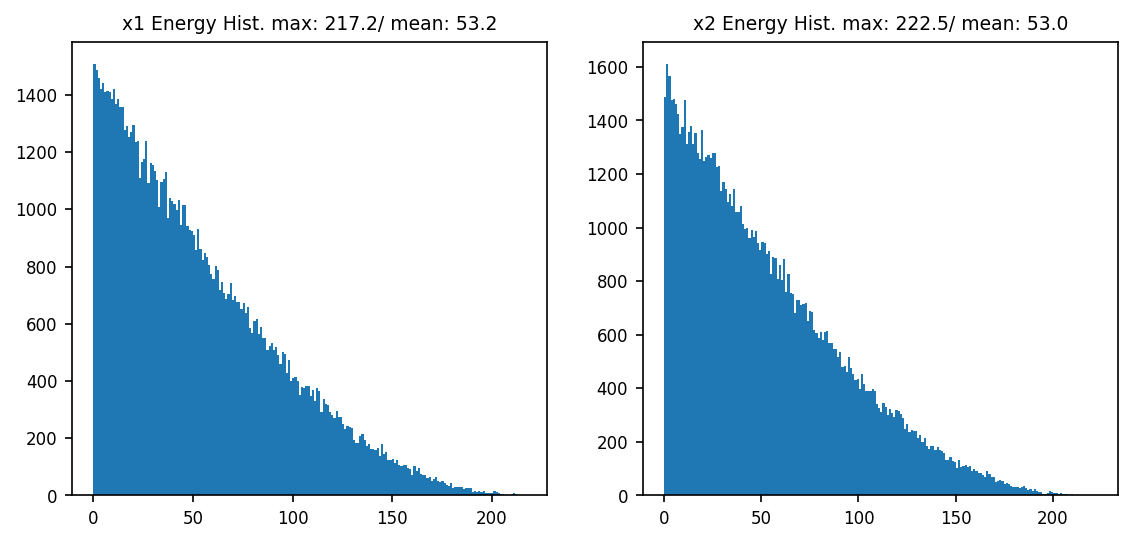

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(X[:,0] , bins=200);
plt.title('x1 Energy Hist. max: ' 
          + str(np.round(np.max(X[:,0]), 1)) 
          + '/ mean: '
          + str(np.round(np.mean(X[:,0]), 1)), fontsize=9);

plt.subplot(1,2,2)
plt.hist(X[:,5] , bins=200);
plt.title('x2 Energy Hist. max: ' 
          + str(np.round(np.max(X[:,5]), 1)) 
          + '/ mean: '
          + str(np.round(np.mean(X[:,5]), 1)), fontsize=9);

### Energy histogram (after smear)

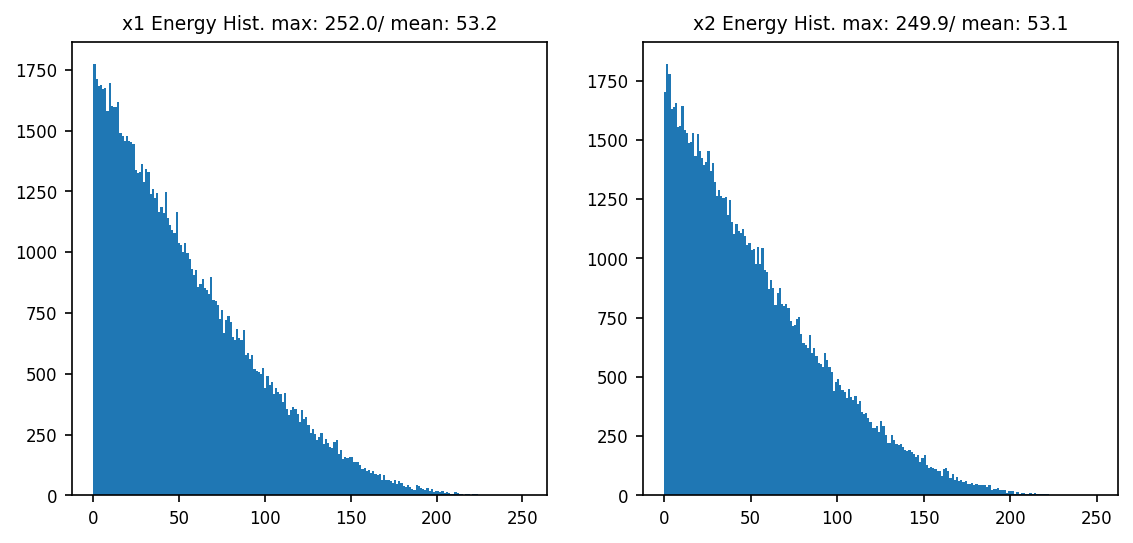

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.hist(X_smear[:,0] , bins=200);
plt.title('x1 Energy Hist. max: ' 
          + str(np.round(np.max(X_smear[:,0]), 1)) 
          + '/ mean: '
          + str(np.round(np.mean(X_smear[:,0]), 1)), fontsize=9);

plt.subplot(1,2,2)
plt.hist(X_smear[:,5] , bins=200);
plt.title('x2 Energy Hist. max: ' 
          + str(np.round(np.max(X_smear[:,5]), 1)) 
          + '/ mean: '
          + str(np.round(np.mean(X_smear[:,5]), 1)), fontsize=9);

### Mass histogram after smearing of E, $\phi$, $\theta$ 

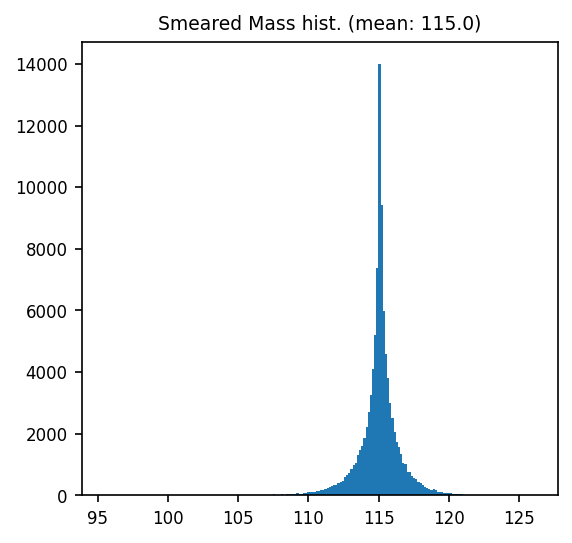

In [8]:
# Mass hist.
plt.figure()
plt.subplot(1,2,1)
plt.hist(X_smear[:,4] , bins=200);
plt.title('Smeared Mass hist. (mean: ' + str(np.round(np.mean(X_smear[:,4]), 1)) + ')', fontsize=9);

### ϕ,  θ histograms

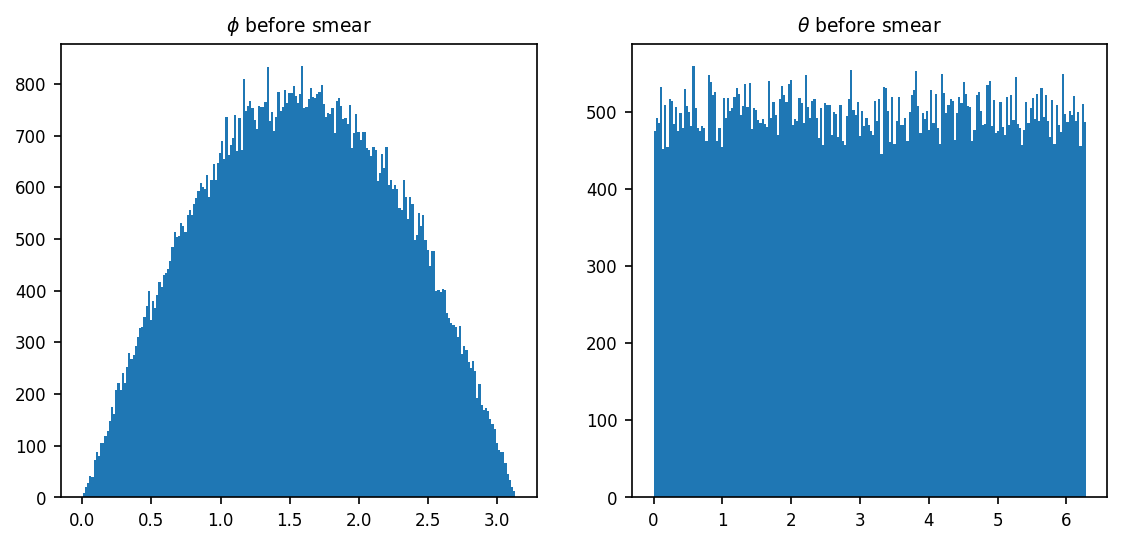

In [9]:
#phi and theta hist. before smear
plt.figure()
plt.subplot(1,2,1)
plt.hist(cart_to_spher(X[:,1],X[:,2],X[:,3])[1], bins=200);
plt.title('$\phi$ before smear', fontsize=9);

plt.subplot(1,2,2)
plt.hist(cart_to_spher(X[:,1],X[:,2],X[:,3])[2] , bins=200);
plt.title('$\\theta$ before smear', fontsize=9);

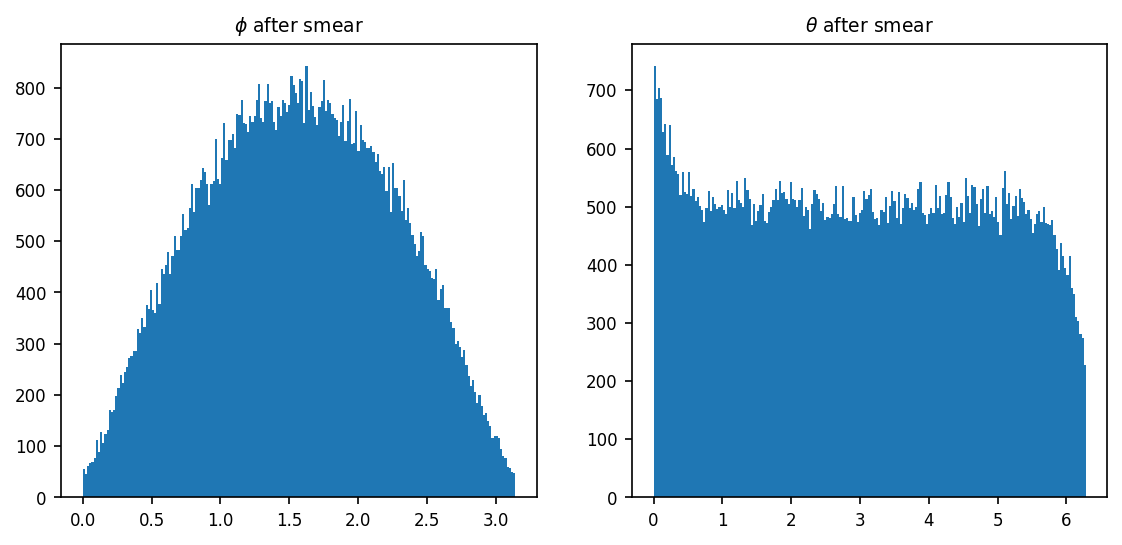

In [10]:
#phi and theta hist. after smear
plt.figure()
plt.subplot(1,2,1)
plt.hist(cart_to_spher(X_smear[:,1],X_smear[:,2],X_smear[:,3])[1], bins=200);
plt.title('$\phi $ after smear', fontsize=9);

plt.subplot(1,2,2)
plt.hist(cart_to_spher(X_smear[:,1],X_smear[:,2],X_smear[:,3])[2] , bins=200);
plt.title('$\\theta$ after smear', fontsize=9);

### Momentum histogram

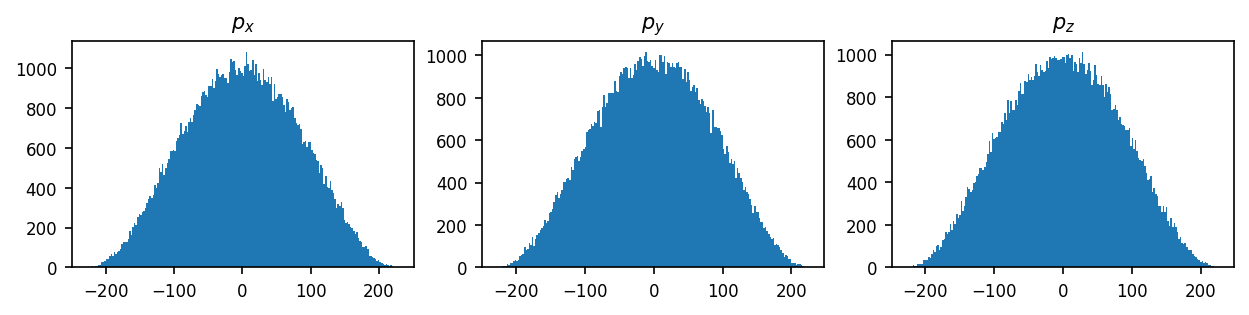

In [11]:
#momentum histograms
# plt.figure(figsize=(10,4), dpi=150)
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.hist(X[:,1], bins=200);
plt.title('$p_x$', fontsize=10);

plt.subplot(1,3,2)
plt.hist(X[:,2], bins=200);
plt.title('$p_y$', fontsize=10);

plt.subplot(1,3,3)
plt.hist(X[:,3], bins=200);
plt.title('$p_z$', fontsize=10);

### Relativistic dispersion relation

Text(0, 0.5, 'Total Momentum (kg⋅m/s)')

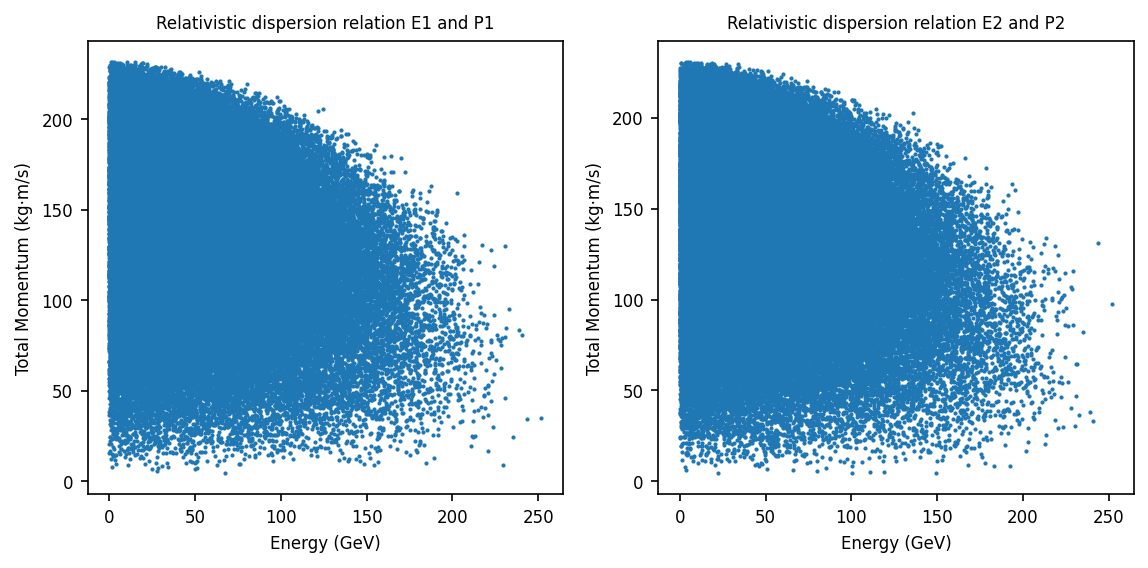

In [12]:
P1 = np.sqrt(X_smear[:, 1]**2 + X_smear[:, 2]**2 + X_smear[:, 3]**2)
P2 = np.sqrt(X_smear[:, 6]**2 + X_smear[:, 7]**2 + X_smear[:, 8]**2)

plt.figure()
plt.subplot(1,2,1)
plt.scatter(X_smear[:, 0], P1, s=1);
plt.title('Relativistic dispersion relation E1 and P1', fontsize=8);
plt.xlabel('Energy (GeV)', fontsize=8)
plt.ylabel('Total Momentum (kg⋅m/s)', fontsize=8)

plt.subplot(1,2,2)
plt.scatter(X_smear[:, 0], P2, s=1);
plt.title('Relativistic dispersion relation E2 and P2', fontsize=8);
plt.xlabel('Energy (GeV)', fontsize=8)
plt.ylabel('Total Momentum (kg⋅m/s)', fontsize=8)

## Create dataset and save

In [13]:
df = pd.DataFrame(X_smear, columns=['E1', 'p_x1', 'p_y1', 'p_z1', 'm1',
                                    'E2', 'p_x2', 'p_y2', 'p_z2', 'm2'])

df.insert(0, 'event_id', range(1, 1 + len(df)))
df.to_csv('./generated_dataset.csv', index=False)

In [14]:
np.round(df.head(5), 2)

,event_id,E1,p_x1,p_y1,p_z1,m1,E2,p_x2,p_y2,p_z2,m2
0,1,30.65,57.05,98.41,0.14,115.13,85.37,106.34,-0.27,-127.45,115.13
1,2,50.28,-26.68,97.75,-55.74,118.24,92.88,-51.44,77.17,75.43,118.24
2,3,41.76,-2.52,9.10,-108.73,114.84,45.24,-35.75,80.42,165.12,114.84
3,4,16.85,49.43,38.69,-201.47,114.94,62.53,-6.37,-46.14,-36.15,114.94
4,5,24.09,-82.07,-27.08,32.06,115.65,41.89,-19.89,-74.54,-184.94,115.65


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
event_id,100000.0,50000.500000,28867.657797,1.000000,25000.750000,50000.500000,75000.250000,100000.000000
E1,100000.0,53.197169,41.623965,0.000384,19.460412,43.728961,78.225623,251.956655
p_x1,100000.0,-0.442338,81.719622,-226.270185,-60.139132,-0.539657,59.466549,227.939204
p_y1,100000.0,0.822268,82.314244,-226.625900,-59.902621,3.827829,60.862922,221.201996
p_z1,100000.0,0.740310,82.316632,-227.829223,-59.879414,1.004186,61.422776,226.061365
m1,100000.0,115.035705,1.520851,95.444251,114.558859,115.102765,115.606732,126.233004
E2,100000.0,53.066801,41.554377,0.000180,19.559655,43.686006,77.757365,249.900541
p_x2,100000.0,-0.579811,81.889865,-225.811358,-60.709424,-0.714501,59.374593,226.232365
p_y2,100000.0,0.806802,82.330327,-225.195177,-60.056645,3.753389,60.714088,227.005792
p_z2,100000.0,1.113655,82.492508,-223.030346,-59.196508,1.260752,61.769086,223.736952


In [16]:
df.shape

(100000, 11)

## Generative model for simulation

# VAE

In [46]:
# Shape of an individual datapoint that will serve as input to our network
input_shape = (nr_features,)

# Properties of the hidden layer of the encoder
size_encoder_hidden = 50
activation_encoder_hidden = 'sigmoid'

# Properties of the latent space
size_latent = 2

In [47]:
inputs = Input(shape=input_shape, name="encoder_input")
encoder_hidden1 = Dense(size_encoder_hidden, activation=activation_encoder_hidden, name="encoder_hidden1")(inputs)

# encoder_bn1 = BatchNormalization()(encoder_hidden1)
# encoder_dropout = Dropout(0.05)(encoder_bn1)

# encoder_hidden2 = Dense(20, activation=activation_encoder_hidden, name="encoder_hidden2")(encoder_dropout)
# encoder_bn2 = BatchNormalization()(encoder_hidden2)
# encoder_dropout2 = Dropout(0.15)(encoder_bn2)
# encoder_hidden3 = Dense(20, activation=activation_encoder_hidden, name="encoder_hidden3")(encoder_dropout2)

z_mean = Dense(size_latent, activation='linear', name="mean")(encoder_hidden1)
z_log_var = Dense(size_latent, activation='linear', name="logvariance")(encoder_hidden1)

In [48]:
def sample(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sample, output_shape=(size_latent,), name="z")([z_mean, z_log_var])

In [49]:
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

In [50]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 encoder_hidden1 (Dense)        (None, 50)           550         ['encoder_input[0][0]']          
                                                                                                  
 mean (Dense)                   (None, 2)            102         ['encoder_hidden1[0][0]']        
                                                                                                  
 logvariance (Dense)            (None, 2)            102         ['encoder_hidden1[0][0]']        
                                                                                            

In [51]:
decoder_input  = Input(shape=(size_latent,), name="decoder_input")
decoder_hidden1 = Dense(50, activation=activation_encoder_hidden, name="decoder_hidden1")(decoder_input)
# decoder_bn1 = BatchNormalization()(decoder_hidden1)

# decoder_dropout = Dropout(0.05)(decoder_bn1)
# decoder_hidden2 = Dense(size_encoder_hidden, activation=activation_encoder_hidden, name="decoder_hidden2")(decoder_dropout)
# decoder_bn2 = BatchNormalization()(decoder_hidden2)
# decoder_dropout2 = Dropout(0.15)(decoder_bn2)
# decoder_hidden3 = Dense(size_encoder_hidden, activation=activation_encoder_hidden, name="decoder_hidden3")(decoder_dropout2)
decoder_output = Dense(input_shape[0], activation="linear", name="decoder_outputs")(decoder_hidden1)

In [52]:
decoder = Model(decoder_input, decoder_output, name="decoder")

In [53]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_hidden1 (Dense)     (None, 50)                150       
                                                                 
 decoder_outputs (Dense)     (None, 10)                510       
                                                                 
Total params: 660
Trainable params: 660
Non-trainable params: 0
_________________________________________________________________


In [54]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name="vae")

In [55]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 encoder (Functional)        [(None, 2),               754       
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 10)                660       
                                                                 
Total params: 1,414
Trainable params: 1,414
Non-trainable params: 0
_________________________________________________________________


In [56]:
xent_loss = mse(inputs, outputs)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(xent_loss + 0.01*kl_loss)

In [57]:
vae.add_loss(vae_loss)
opt = Adam(learning_rate=0.001)
vae.compile(optimizer=opt, metrics=None)

In [58]:
sk = StandardScaler()
X_smear_normal = sk.fit_transform(X_smear)

In [59]:
result = vae.fit(X_smear_normal, validation_split=0.2, epochs=300, batch_size=128)

Epoch 1/300
625/625 [==============================] - 2s 3ms/step - loss: 0.8262 - val_loss: 0.7328
Epoch 2/300
625/625 [==============================] - 2s 3ms/step - loss: 0.7191 - val_loss: 0.7135
Epoch 3/300
625/625 [==============================] - 2s 3ms/step - loss: 0.7099 - val_loss: 0.7093
Epoch 4/300
625/625 [==============================] - 2s 3ms/step - loss: 0.7050 - val_loss: 0.7014
Epoch 5/300
625/625 [==============================] - 2s 3ms/step - loss: 0.6948 - val_loss: 0.6906
Epoch 6/300
625/625 [==============================] - 2s 3ms/step - loss: 0.6855 - val_loss: 0.6832
Epoch 7/300
625/625 [==============================] - 2s 3ms/step - loss: 0.6813 - val_loss: 0.6805
Epoch 8/300
625/625 [==============================] - 2s 3ms/step - loss: 0.6794 - val_loss: 0.6796
Epoch 9/300
625/625 [==============================] - 2s 3ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 10/300
625/625 [==============================] - 2s 3ms/step - loss: 0.6771 - val_lo

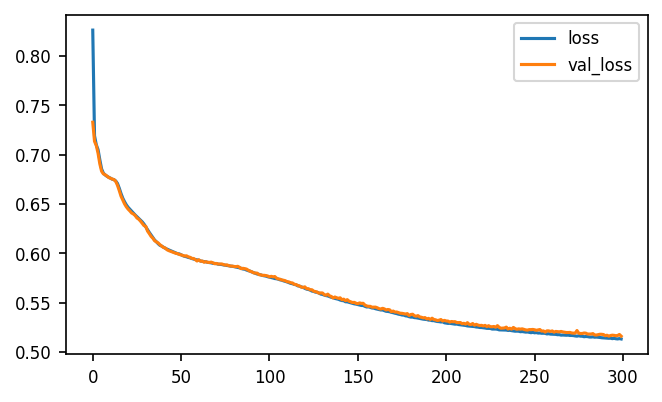

In [60]:
plt.figure(figsize=(5,3))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(result.history)

## Sampling with VAE

In [61]:
samples_from_latent_space = encoder.predict(X_smear)[2]
X_fake_normal = decoder.predict(samples_from_latent_space)

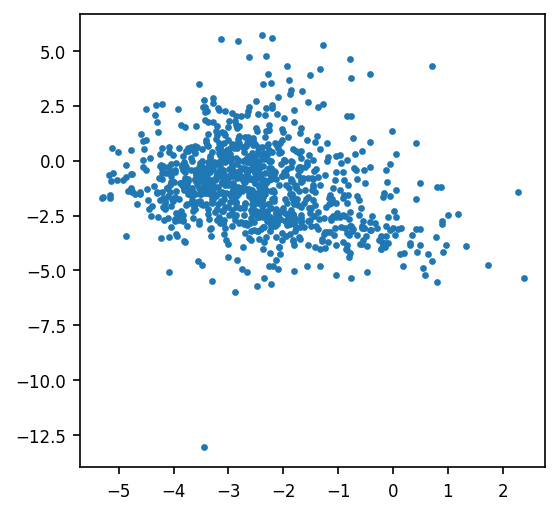

In [62]:
plt.figure(figsize=(4,4))
plt.scatter(samples_from_latent_space[:1000,0],samples_from_latent_space[:1000,1],s=5)

In [63]:
X_fake = sk.inverse_transform(X_fake_normal)

## Compaire Energy histograms

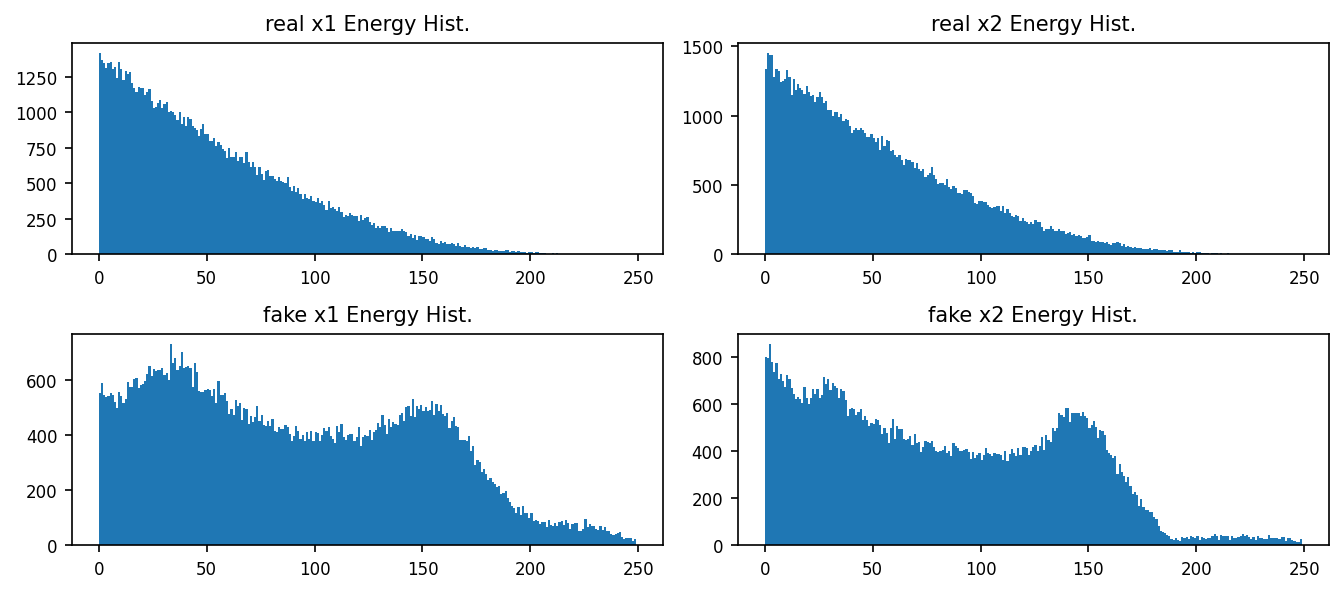

In [64]:
plt.figure()
plt.subplot(2,2,1)
energy_bins = range(250)
x1_real_energy = plt.hist(X_smear[:,0] , bins=energy_bins)[0]
plt.title('real x1 Energy Hist.', fontsize=10)

plt.subplot(2,2,2)
x2_real_energy = plt.hist(X_smear[:,5] , bins=energy_bins)[0]
plt.title('real x2 Energy Hist.', fontsize=10)


plt.subplot(2,2,3)

x1_fake_energy = plt.hist(X_fake[:,0] , bins=energy_bins)[0]

plt.title('fake x1 Energy Hist.', fontsize=10)

plt.subplot(2,2,4)
x2_fake_energy = plt.hist(X_fake[:,5] , bins=energy_bins)[0]

plt.title('fake x2 Energy Hist.', fontsize=10)
plt.tight_layout()

## KL divergence as a merit fucntion

In [65]:
def kl_divergence(p, q):
  p = p / np.sum(p)
  q = q / np.sum(q)
  return np.sum(p[i] * np.log2((p[i]+0.001)/(q[i]+0.001)) for i in range(len(p)))

In [66]:
print('x1 real and fake energy KL difference: ' , np.round(kl_divergence(x1_real_energy, x1_fake_energy), 2))
print('x2 real and fake energy KL difference: ' , np.round(kl_divergence(x2_real_energy, x2_fake_energy), 2))

x1 real and fake energy KL difference:  0.36
x2 real and fake energy KL difference:  0.27


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


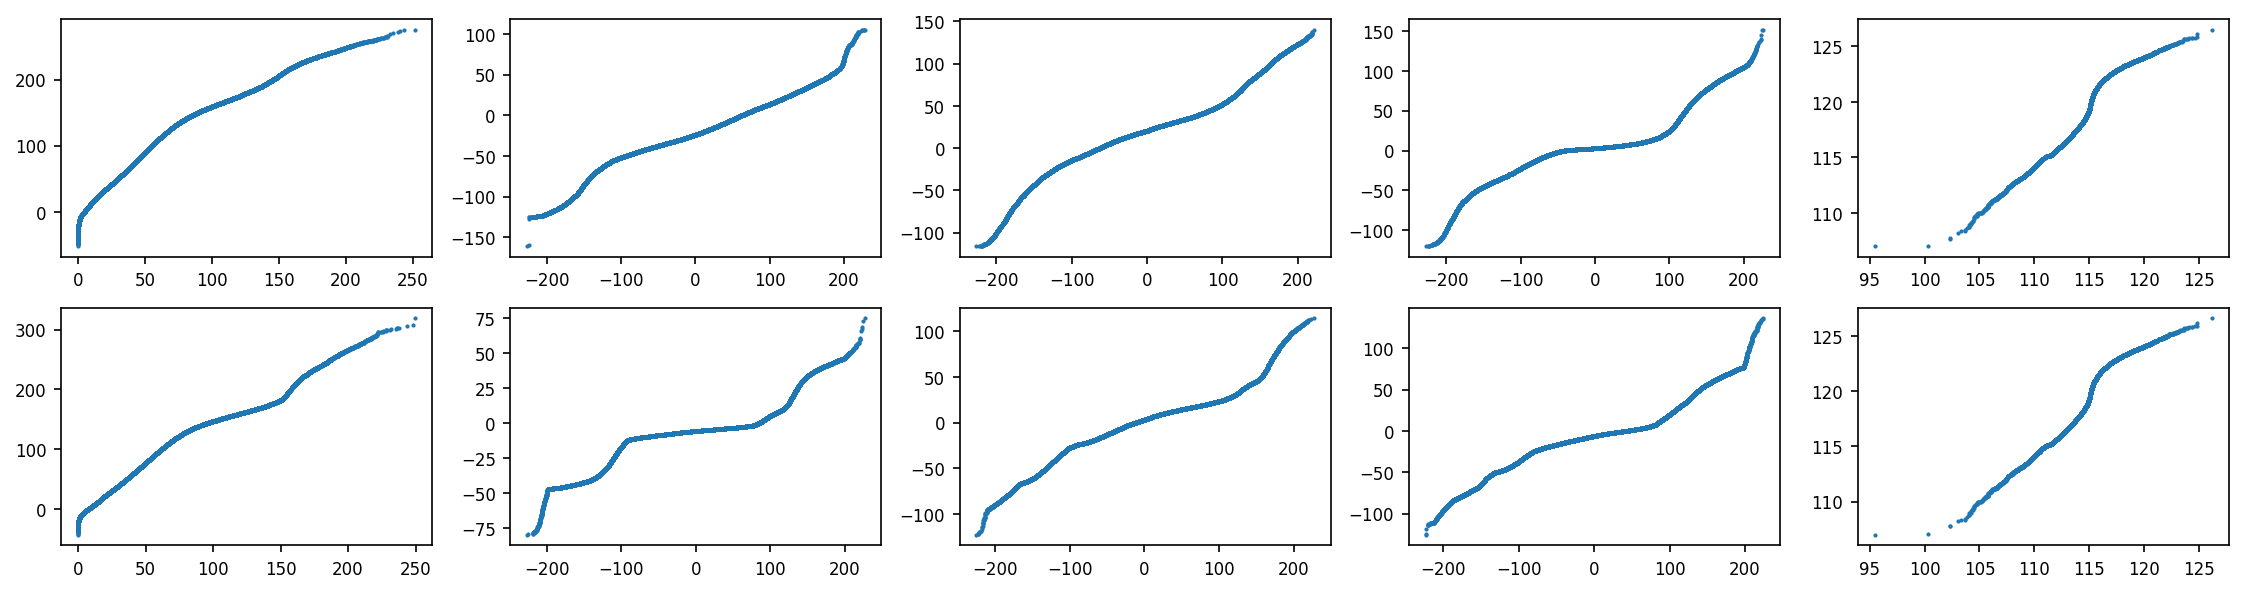

In [67]:
plt.figure(figsize=(15,4))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.scatter(np.sort(X_smear[:,i]), np.sort(X_fake[:,i]), s=1)
  
plt.tight_layout()

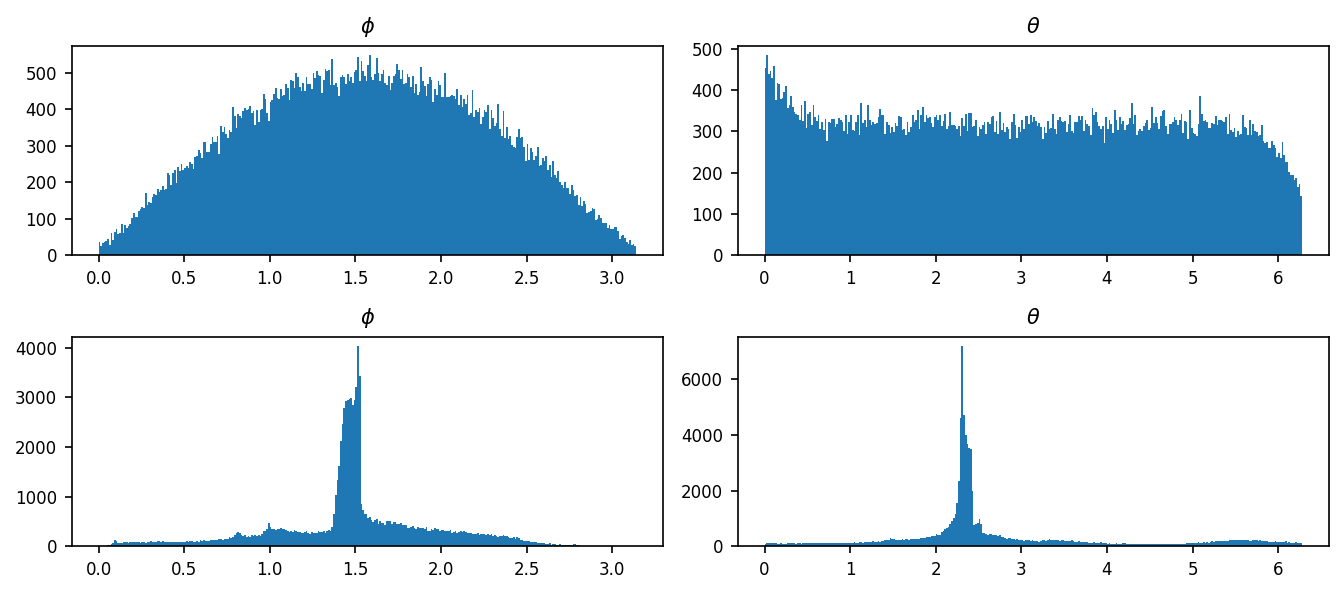

In [68]:
plt.figure()
plt.subplot(2,2,1)
x1_real_phi = plt.hist(cart_to_spher(X_smear[:,1],X_smear[:,2],X_smear[:,3])[1], bins=np.arange(0,np.pi , 0.01))[0];
plt.title('$\phi$', fontsize=10);

plt.subplot(2,2,2)
x1_real_theta = plt.hist(cart_to_spher(X_smear[:,1],X_smear[:,2],X_smear[:,3])[2] , bins=np.arange(0,2*np.pi , 0.02))[0];
plt.title('$\\theta$', fontsize=10);


plt.subplot(2,2,3)
x1_fake_phi = plt.hist(cart_to_spher(X_fake[:,1],X_fake[:,2],X_fake[:,3])[1], bins=np.arange(0,np.pi , 0.01))[0];
plt.title('$\phi$', fontsize=10);

plt.subplot(2,2,4)
x1_fake_theta = plt.hist(cart_to_spher(X_fake[:,1],X_fake[:,2],X_fake[:,3])[2] , bins=np.arange(0,2*np.pi , 0.02))[0];
plt.title('$\\theta$', fontsize=10);
plt.tight_layout()

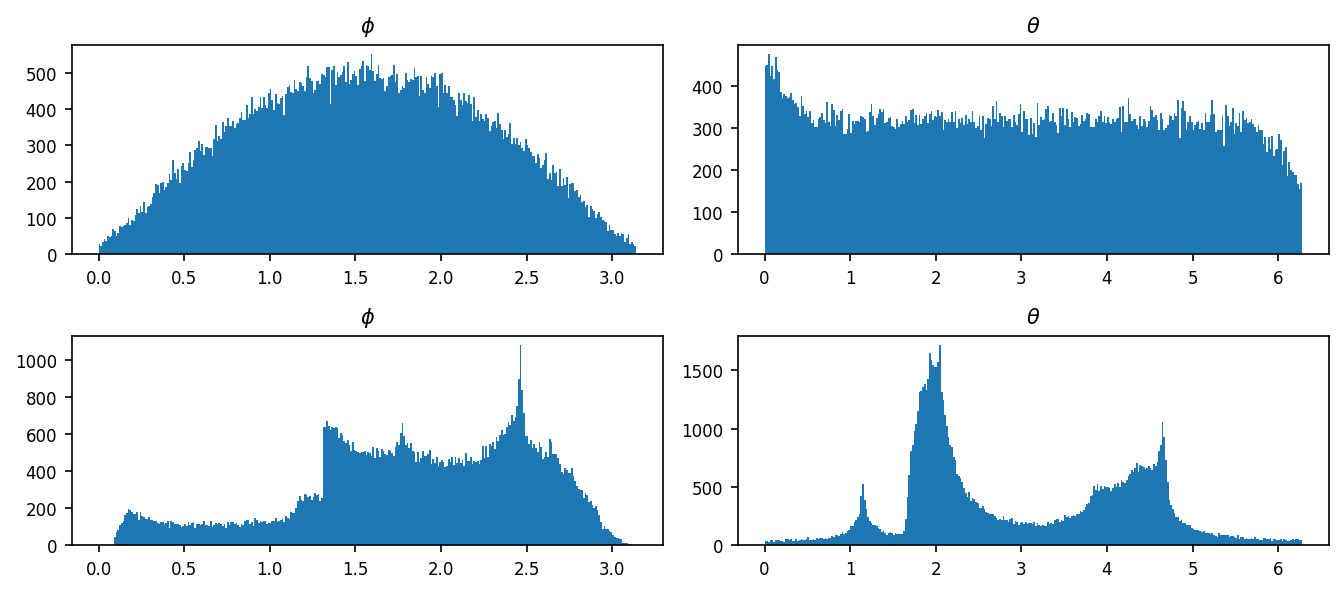

In [69]:
plt.figure()
plt.subplot(2,2,1)
x2_real_phi = plt.hist(cart_to_spher(X_smear[:,6],X_smear[:,7],X_smear[:,8])[1], bins=np.arange(0,np.pi , 0.01))[0];
plt.title('$\phi$', fontsize=10);

plt.subplot(2,2,2)
x2_real_theta = plt.hist(cart_to_spher(X_smear[:,6],X_smear[:,7],X_smear[:,8])[2] , bins=np.arange(0,2*np.pi , 0.02))[0];
plt.title('$\\theta$', fontsize=10);


plt.subplot(2,2,3)
x2_fake_phi = plt.hist(cart_to_spher(X_fake[:,6],X_fake[:,7],X_fake[:,8])[1], bins=np.arange(0,np.pi , 0.01))[0];
plt.title('$\phi$', fontsize=10);

plt.subplot(2,2,4)
x2_fake_theta = plt.hist(cart_to_spher(X_fake[:,6],X_fake[:,7],X_fake[:,8])[2] , bins=np.arange(0,2*np.pi , 0.02))[0];
plt.title('$\\theta$', fontsize=10);
plt.tight_layout()
plt.tight_layout()

In [70]:
print('x1 real and fake $\phi$ KL difference: ' , np.round(kl_divergence(x1_real_phi, x1_fake_phi), 2))
print('x1 real and fake $\theta$ KL difference: ' , np.round(kl_divergence(x1_real_theta, x1_fake_theta), 2))
print('x2 real and fake $\phi$ KL difference: ' , np.round(kl_divergence(x1_real_phi, x1_fake_phi), 2))
print('x2 real and fake $\theta$ KL difference: ' , np.round(kl_divergence(x2_real_theta, x2_fake_theta), 2))

x1 real and fake $\phi$ KL difference:  0.28
x1 real and fake $	heta$ KL difference:  0.47
x2 real and fake $\phi$ KL difference:  0.28
x2 real and fake $	heta$ KL difference:  0.38


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


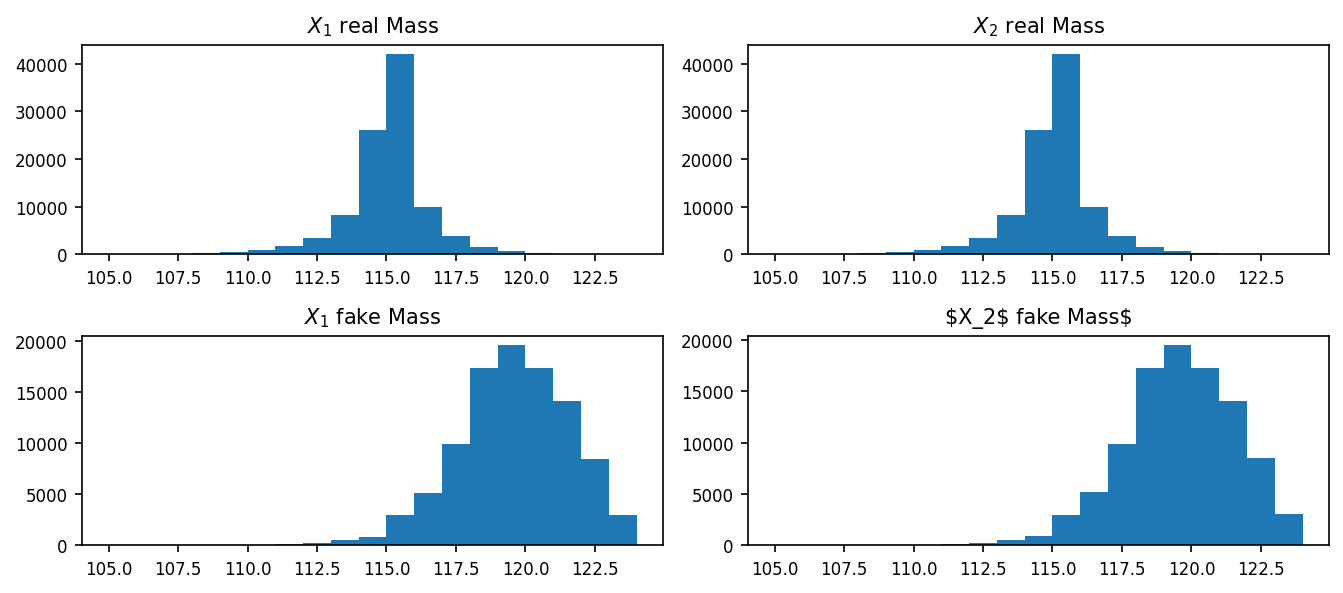

In [71]:
plt.figure()
plt.subplot(2,2,1)
mass_bins = range(105, 125)
x1_real_mass = plt.hist(X_smear[:,4], bins=mass_bins)[0];
plt.title('$X_1$ real Mass', fontsize=10);

plt.subplot(2,2,2)
x2_real_mass = plt.hist(X_smear[:,9] , bins=mass_bins)[0];
plt.title('$X_2$ real Mass', fontsize=10);


plt.subplot(2,2,3)
x1_fake_mass = plt.hist(X_fake[:,4], bins=mass_bins)[0];
plt.title('$X_1$ fake Mass', fontsize=10);

plt.subplot(2,2,4)
x2_fake_mass = plt.hist(X_fake[:,9], bins=mass_bins)[0];
plt.title('$X_2$ fake Mass$', fontsize=10);
plt.tight_layout()
plt.tight_layout()

In [72]:
print('x1 real and fake mass KL difference: ', np.round(kl_divergence(x1_real_mass , x1_fake_mass), 2))
print('x2 real and fake mass KL difference: ',  np.round(kl_divergence(x2_real_mass , x2_fake_mass), 2))

x1 real and fake mass KL difference:  3.27
x2 real and fake mass KL difference:  3.26


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


# Save fake dataset (VAE dataset)


In [73]:
df = pd.DataFrame(X_fake, columns=['E1', 'p_x1', 'p_y1', 'p_z1', 'm1',
                                    'E2', 'p_x2', 'p_y2', 'p_z2', 'm2'])

df.insert(0, 'event_id', range(1, 1 + len(df)))
df.to_csv('./fake_generated_dataset_by_VAE.csv', index=False)

# Save/Load the Keras model

In [74]:
import os
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pickle

if not os.path.exists('./VAE_Model.hdf5'):
  vae.save('./VAE_Model.hdf5', save_format='tf')
  
  with open("scaler_model.pickle", "wb") as file_:
    pickle.dump([sk],file_)

else:
  vae = load_model('./VAE_Model.hdf5')
  with open("./scaler_model.pickle", "rb") as file_:
    sk = pickle.load(file_)